# Кластеризация

Перед тем, как приступить к практике, **ответим на следующие вопросы**:

<ol>
    <li>Чем отличаеться обучение с учителем от обучения без учителя?</li>
    <li>Какую цель мы приследуем используя подходы без учителя?</li>
    <li>Когда нам может быть полезна кластеризация в "реальной жизни"?</li>
</ol>

На данном семинаре мы будем использовать различные подходы, разработанные для выделение групп объектов с похожими свойствами, для кластеризации фильмов опубликованных на [Netflix](https://www.kaggle.com/shivamb/netflix-shows).

## Данные

Прочитайте таблицу `Netflix.csv` и возьмём только строки с описанием фильмов, у которых есть текстовое описание:

In [1]:
import pandas as pd

table = pd.read_csv('data/Netflix.csv', index_col=0)

table = table[table['type'] == 'Movie']
table = table[table['description'].notna()]

print(f'Total rows: {len(table)}')

Total rows: 6131


## Векторизация текста

<details>
  <summary>Какие базовые способы векторизации текста вы знаете?</summary>
    <ol>
      <li><b>BOW</b>: <a href=https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html>sklearn.feature_extraction.text.CountVectorizer</a></li>
      <li><b>Tf-Idf</b>: <a href=https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfIdfVectorizer.html>sklearn.feature_extraction.text.TfidfVectorizer</a></li>
    </ol> 
    
    Также ответим на следующие вопросы: 
    
    <ol>
        <li>Какие недостатки у данных методов векторизации?</li>
        <li>Почему предпочтём <i>Tf-Idf</i> перед <i>BOW</i>?</li>
    </ol>
</details>

Используя один из базовых способов векторизации, преобразуем описания фильмов:

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')

X = vectorizer.fit_transform(table['description'])

vocabulary = vectorizer.get_feature_names_out()

X = pd.DataFrame(X.toarray(), columns=vocabulary, index=table.index)

X = X[X.sum(axis=1) != 0]

X.head(3)

000   10  100   11   12   13   14   15  1590   16  ...  york  young  \
show_id                                                     ...                
s1       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0    0.0   
s7       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0    0.0   
s8       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0    0.0   

         younger  youth  youtube  zack  zany  zealand  zombie  zone  
show_id                                                              
s1           0.0    0.0      0.0   0.0   0.0      0.0     0.0   0.0  
s7           0.0    0.0      0.0   0.0   0.0      0.0     0.0   0.0  
s8           0.0    0.0      0.0   0.0   0.0      0.0     0.0   0.0  

[3 rows x 3530 columns]

## Визуализация данных

<details>
  <summary>Как нам визуализировать наши данные на плоскости?</summary>
  
  Воспользуемся <a href=https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html>sklearn.manifold.TSNE</a>
    
</details>

/external2/dkkoshman/venv3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/external2/dkkoshman/venv3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


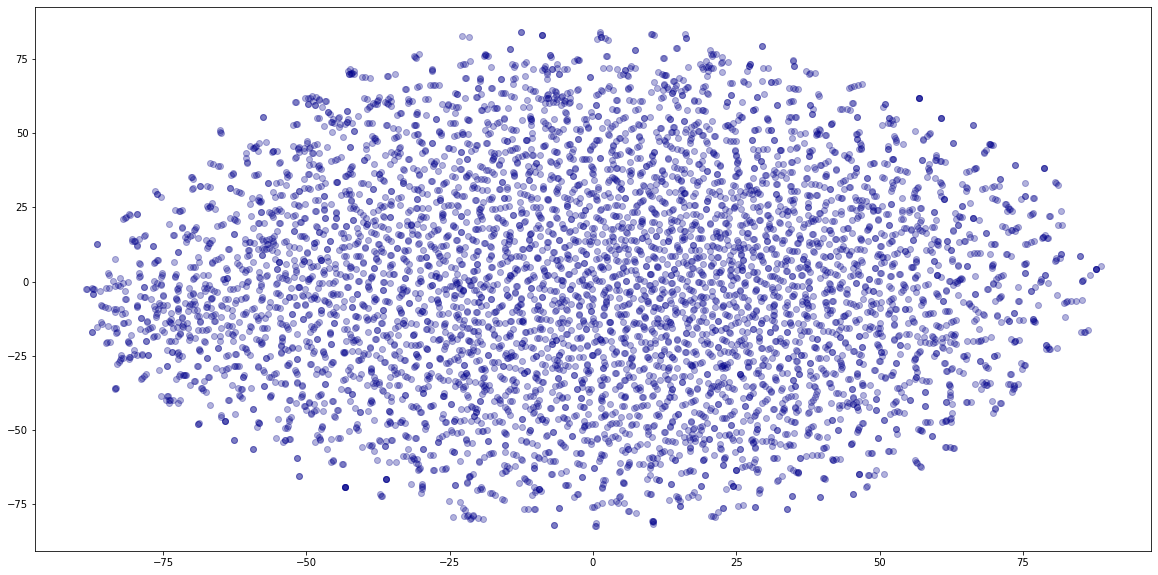

In [4]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

X_2d = TSNE().fit_transform(X)

plt.figure(figsize=(20, 10))
plt.scatter(*zip(*X_2d), color='darkblue', alpha=0.3)
plt.show()

## Метод К-средних

Сейчас перед нами стоит задача самостоятельно реализовать *метод K-средних*

<details>
    <summary>Какой минимальный набор гиперпараметров должна принимать наша базовая реализация?</summary>
    <ol>
        <li><b>n_clusters</b> : <i>int</i> : The number of clusters to form as well as the number of centroids to generate</li>
        <li><b>max_iter</b> : <i>int</i> : Maximum number of iterations of the k-means algorithm for a single run</li>
        <li><b>tol</b> : <i>float</i> : Relative tolerance of the difference in the cluster centers of two consecutive iterations to declare convergence</li>
    </ol>
</details>

Реализуем класс `CustomKMeans`, 

который будет наследоваться от [sklearn.base.ClusterMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.ClusterMixin.html#sklearn.base.ClusterMixin.fit_predict), 

и иметь методы `fit` и `predict`, 

и атрибуты `cluster_centers_` и `labels_`:

In [4]:
import numpy as np

from random import choices
from sklearn.base import ClusterMixin

class CustomKMeans(ClusterMixin):
    def __init__(self, n_clusters=8, max_iter=300, tol=0.0001):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        
    def _init_cluster_centers(self, X):
        indexes = range(len(X))
        indexes = choices(indexes, k=self.n_clusters)
        
        self.cluster_centers_ = X[indexes]
        
    def _distance(self, x):
        return np.sqrt(((x - self.cluster_centers_) ** 2).sum(axis=1))
        
    def predict(self, X):
        return np.array([self._distance(x) for x in X]).argmin(axis=1)
        
    def fit(self, X):
        self._init_cluster_centers(X)
        
        for self.n_iter_ in range(self.max_iter):
            self.labels_ = self.predict(X)

            new_cluster_centers_ = np.array([X[self.labels_ == label].mean(axis=0) for label in range(self.n_clusters)])
            
            if np.abs(new_cluster_centers_ - self.cluster_centers_).sum() < self.tol:
                break
            
            self.cluster_centers_ = new_cluster_centers_
        
        return self

Посмотрим за сколько имерация сошлась наша реализация метода:

In [11]:
from tqdm import tqdm

n_start = 10
n_iters = [CustomKMeans().fit(X.values).n_iter_ for _ in tqdm(range(n_start))]

print(f'Mean {sum(n_iters) / n_start} iterations' )

100%|██████████| 10/10 [01:08<00:00,  6.80s/it]

Mean 19.8 iterations


In [12]:
n_iters

[12, 17, 35, 37, 15, 7, 15, 21, 17, 22]

Сравним скорость сходимости с реализацияей [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html):

In [13]:
from sklearn.cluster import KMeans

n_iters = [KMeans(init='random', n_init=1, algorithm='full').fit(X.values).n_iter_ for _ in tqdm(range(n_start))]

print(f'Mean {sum(n_iters) / n_start} iterations' )

100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

Mean 17.9 iterations


In [14]:
n_iters

[31, 25, 14, 11, 19, 10, 18, 10, 20, 21]

<details>
    <summary>Какие параметры следует выставить иначе чем дефолтные, чтобы приблизить реализацию из <i>sklearn</i> к нашей реализации?</summary>
    <ol>
        <li><b>init</b>: random</li>
        <li><b>n_init</b>: 1</li>
        <li><b>algorithm</b>: full</li>
    </ol>
</details>

## Визуализация класстеров

Реализуем функцию `cluster_visualisation`, которая в качестве параметров будет принимать:
   
<ol>
    <li><b>X</b> : <i>ndarray</i> : 2d-representations</li>
    <li><b>labels</b> : <i>ndarray</i> : sequence of X's labels</li>
    <li><b>cl_names</b> : <i>list (default None)</i> : clusters names. If cl_names is None then generate names like claster_0</li>
</ol>

In [15]:
def cluster_visualisation(X, labels, cl_names=None):
    plt.figure(figsize=(20, 10))
    
    if not cl_names:
        cl_names = [f'cluster_{label}' for label in sorted(set(labels))]
        
    for cl_label, cl_name in zip(sorted(set(labels)), cl_names):
        plt.scatter(*zip(*X[labels == cl_label]), alpha=0.5, label=f'{cl_name}')
    
    plt.legend(title='Clusters')
    plt.show()

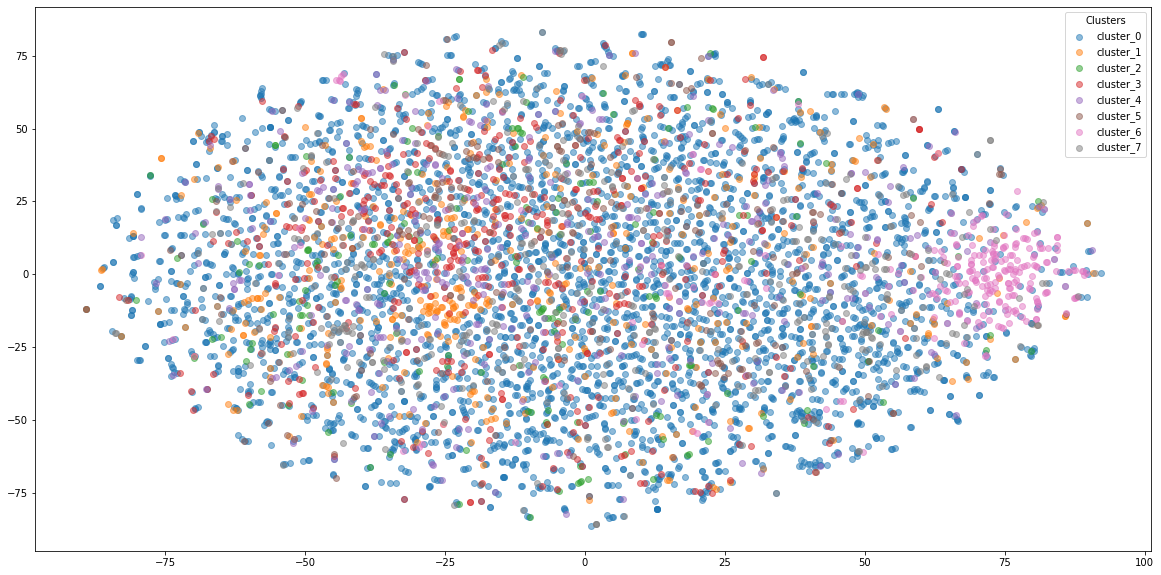

In [16]:
km = CustomKMeans().fit(X.values)

cluster_visualisation(X_2d, km.labels_)

<details>
    <summary>Что мы можем сказать о полученной кластеризации? Как мы можем получить больше информации?</summary>
    
    Глядя на облако точек, мы мало что можем сказать о полученной кластеризации, а уж тем более не возможно понять полезно ли нам то, что мы получили.
    
    Что бы убедиться в адекватности полученных результатов, нужно постараться интерпретировать каждый класс. Как это сделать?
</details>



In [17]:
def cluster_names(cluster_centers, vocabulary, N=5):
    cluster_centers = pd.DataFrame(cluster_centers, columns=vocabulary)
    
    return [', '.join(tokens.sort_values(ascending=False)[:N].index) for label, tokens in cluster_centers.iterrows()]

In [18]:
cl_names = cluster_names(km.cluster_centers_, vocabulary)

for index, cl_name in enumerate(cl_names):
    print(f'cluster_{index}: {cl_name}')

cluster_0: new, documentary, world, friends, love
cluster_1: man, old, year, woman, new
cluster_2: heart, win, plans, discover, girl
cluster_3: young, man, woman, love, father
cluster_4: family, home, life, father, new
cluster_5: wife, women, man, husband, lives
cluster_6: special, stand, comedian, comedy, comic
cluster_7: life, new, love, documentary, woman


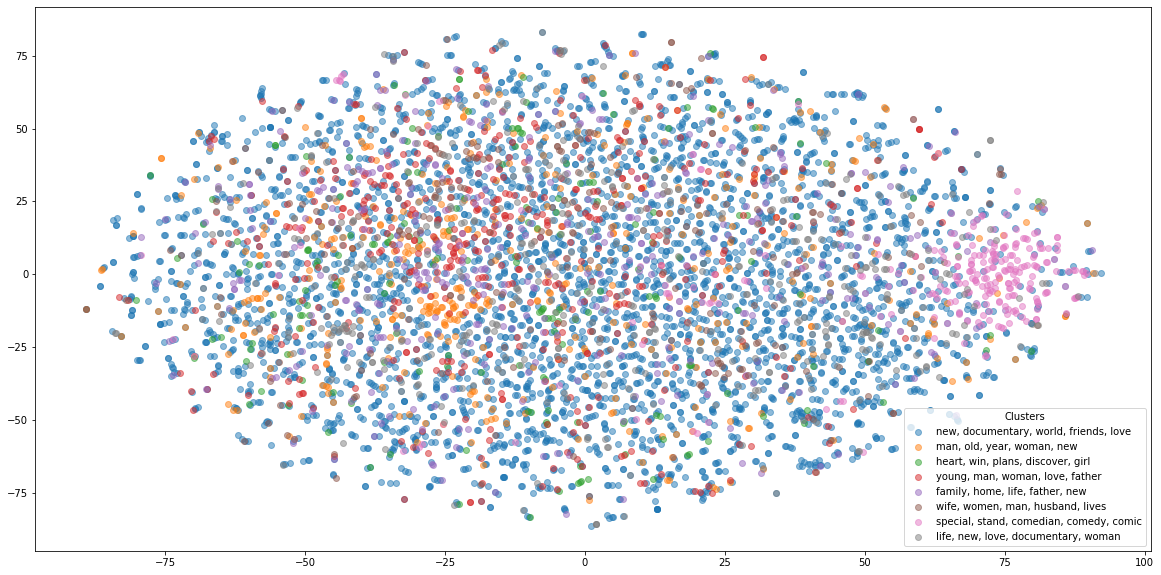

In [19]:
cluster_visualisation(X_2d, km.labels_, cl_names)

## K-means++ 

<ol>
    <li>В чём может заключатся проблема, реализованного нами, подхода инициализации центроидов кластеров?</li>
    <li>Как можно усовершенствовать способ инициализации центроидов кластеров?</li>
</ol>

Усовершенствуем в нашей реализации способ инициализации:

In [20]:
from random import choice, choices

class CustomKMeans(CustomKMeans):
    
    def _init_cluster_centers(self, X):
        indexes = list(range(len(X)))
        
        cluster_centers_index = choice(indexes)
        
        indexes.remove(cluster_centers_index)
        cluster_centers_indexes = [cluster_centers_index]
        
        self.cluster_centers_ = X[cluster_centers_indexes]
        
        for _ in range(self.n_clusters - 1):
            weights = np.array([self._distance(x) for x in X[indexes]]).min(axis=1) ** 2
            cluster_centers_index = choices(indexes, weights=weights, k=1)[0]
            
            indexes.remove(cluster_centers_index)
            cluster_centers_indexes.append(cluster_centers_index)
            
            self.cluster_centers_ = X[cluster_centers_indexes]

In [21]:
n_start = 10
n_iters = [CustomKMeans().fit(X.values).n_iter_ for _ in tqdm(range(n_start))]

print(f'Mean {sum(n_iters) / n_start} iterations' )

100%|██████████| 10/10 [01:32<00:00,  9.24s/it]

Mean 19.4 iterations


In [22]:
n_iters

[14, 21, 13, 10, 21, 28, 17, 33, 10, 27]

In [23]:
n_iters = [KMeans(n_init=1, algorithm='full').fit(X.values).n_iter_ for _ in tqdm(range(n_start))]

print(f'Mean {sum(n_iters) / n_start} iterations' )

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Mean 15.5 iterations


In [24]:
n_iters

[18, 23, 10, 20, 21, 12, 17, 11, 12, 11]

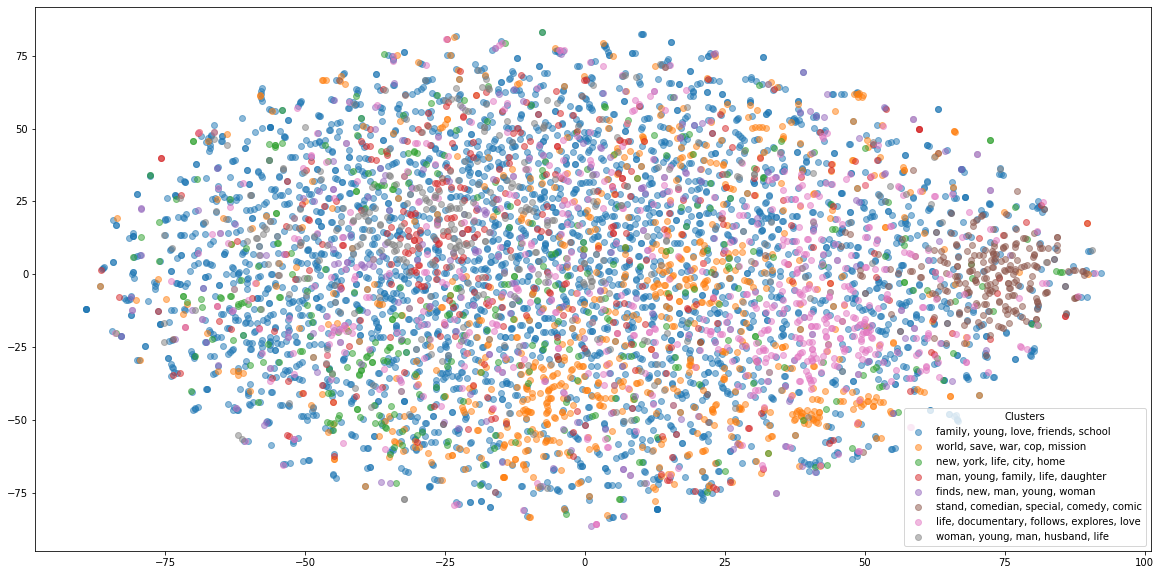

In [25]:
km = CustomKMeans().fit(X.values)

cluster_visualisation(X_2d, km.labels_, cluster_names(km.cluster_centers_, vocabulary))

<details>
    <summary>Можно ли использовать другое расстояние?</summary>
    Попробуем заменить <i>Евклидову метрику</i> на <i>Косинусное расстояние</i>
    
</details>

In [26]:
class CustomKMeans(CustomKMeans):
    def _distance(self, x):
        return 1 - (self.cluster_centers_ * x).sum(axis=1) / ((self.cluster_centers_ ** 2).sum(axis=1) * (x ** 2).sum())

In [27]:
n_start = 10
n_iters = [CustomKMeans().fit(X.values).n_iter_ for _ in tqdm(range(n_start))]

print(f'Mean {sum(n_iters) / n_start} iterations')

100%|██████████| 10/10 [01:36<00:00,  9.66s/it]

Mean 13.4 iterations


In [28]:
n_iters

[27, 14, 15, 10, 12, 8, 13, 14, 10, 11]

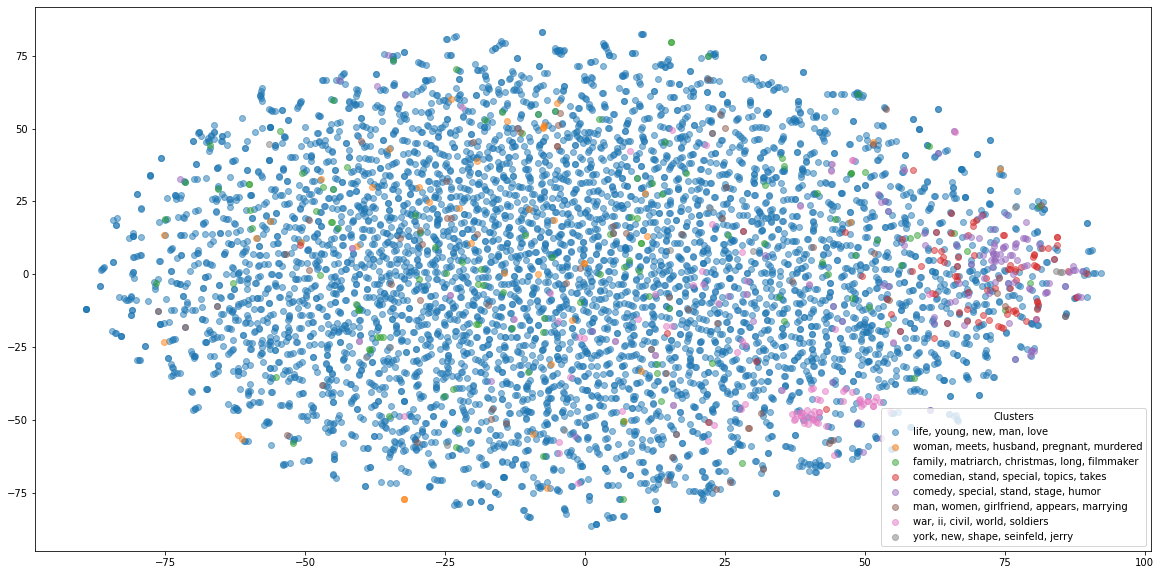

In [29]:
km = CustomKMeans().fit(X.values)

cluster_visualisation(X_2d, km.labels_, cluster_names(km.cluster_centers_, vocabulary))

## Снижение размерности

<details>
    <summary>Как, в данном случае, мы можем снизить размерность данных?</summary>
    
    <ol>
        <li>Использовать <b>PCA</b></li>
        <li>Использовать предобученные вектора слов, например <a href=https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip>wiki-news-300d-1M.vec.zip</a></li>
    </ol>
    
    Давайте воспользуемся вторым вариантом:
</details>

In [30]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    
    return data

embeddings = load_vectors('wiki-news-300d-1M.vec')

999994it [04:50, 3437.26it/s] 


In [31]:
vocabulary = list(set(vocabulary) & set(embeddings))

print(f'Total {len(vocabulary)} tokens')

Total 3523 tokens


In [32]:
X = X[vocabulary]

embeddings = np.array([list(embeddings[token]) for token in vocabulary])

X_300d = X @ embeddings

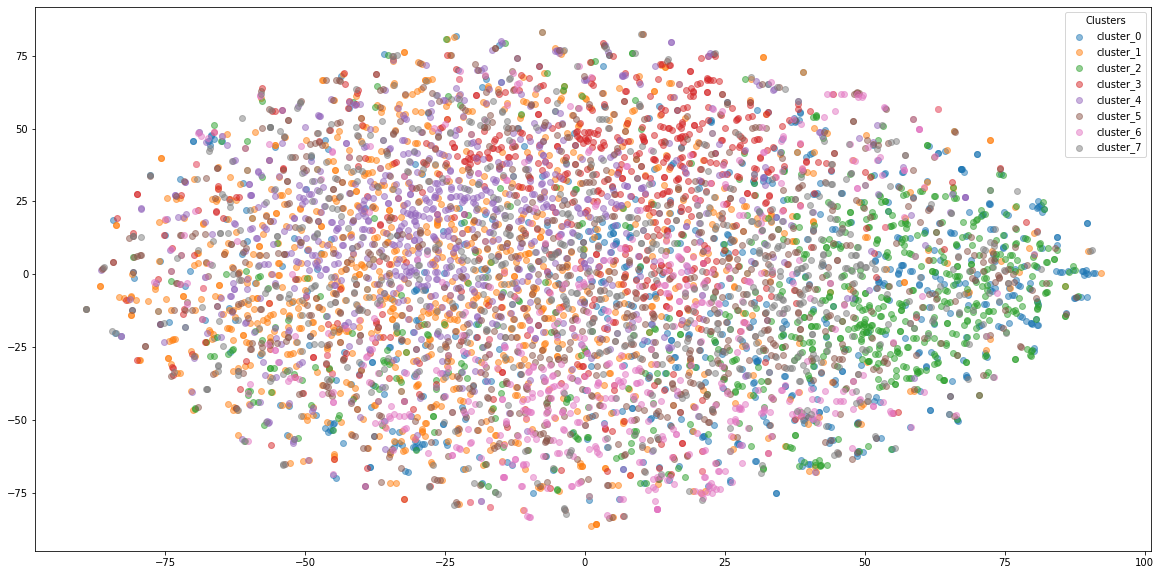

In [33]:
km = KMeans().fit(X_300d.values)

cluster_visualisation(X_2d, km.labels_)

Как в данном случае интерпретировать кластера?

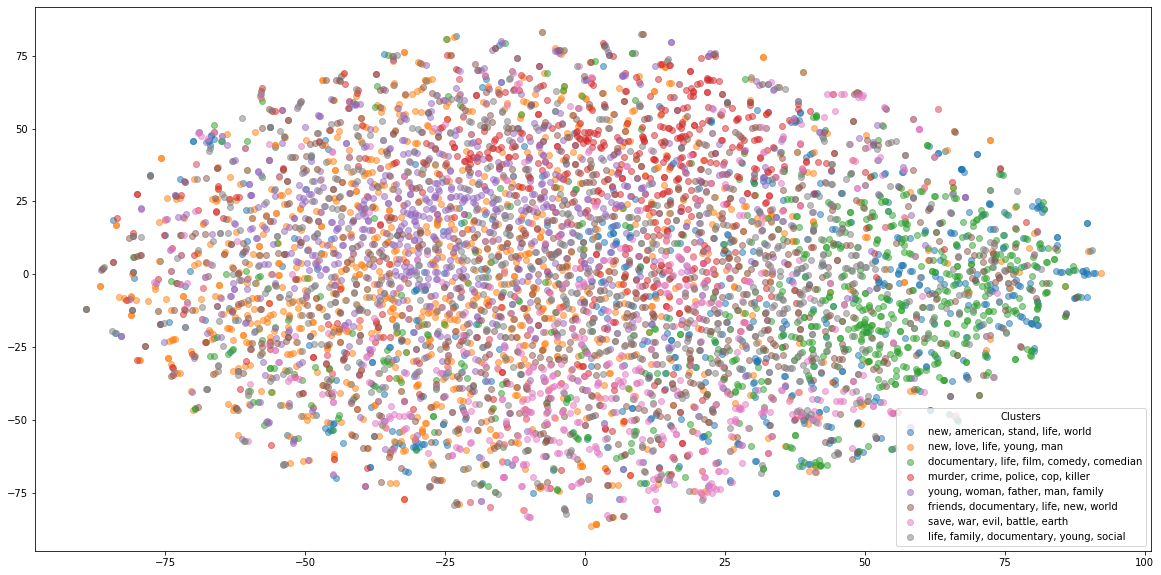

In [34]:
def cluster_names(X, labels, N=5):
    cl_names = []
    for label in sorted(set(labels)):
        cluster_center = X[labels == label].mean(axis=0)
        cl_names.append(', '.join(cluster_center.sort_values(ascending=False)[:N].index))
    
    return cl_names

cluster_visualisation(X_2d, km.labels_, cluster_names(X, km.labels_))

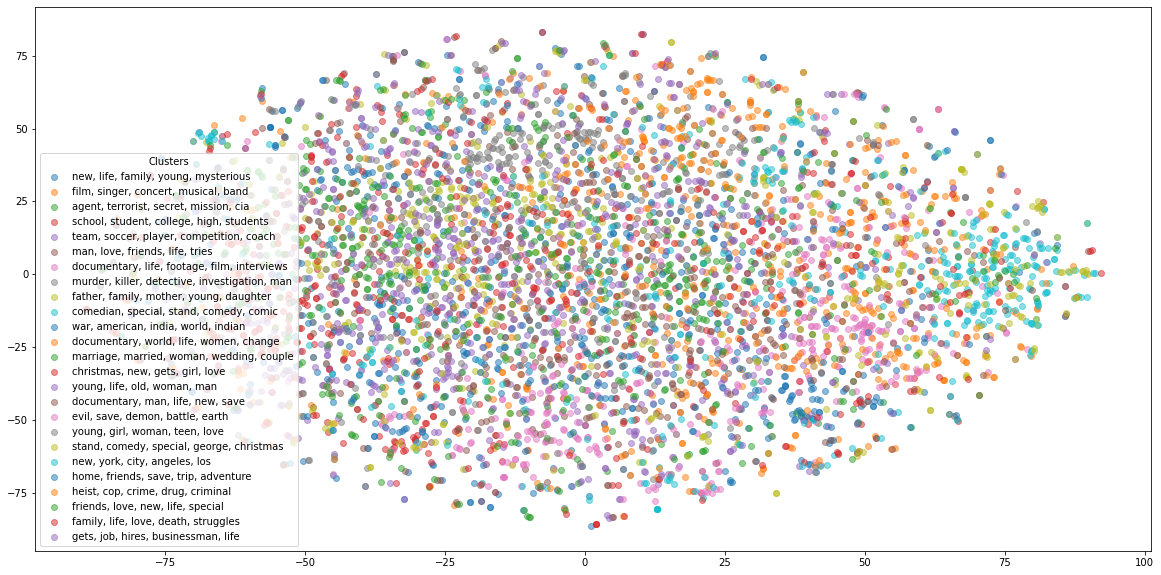

In [35]:
km = KMeans(n_clusters=25).fit(X_300d.values)

cluster_visualisation(X_2d, km.labels_, cluster_names(X, km.labels_))

## DBSCAN

Обучите [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) попробовав подобрать `metric`, `eps` и `min_samples`, так что бы выделились осмысленные кластеры:

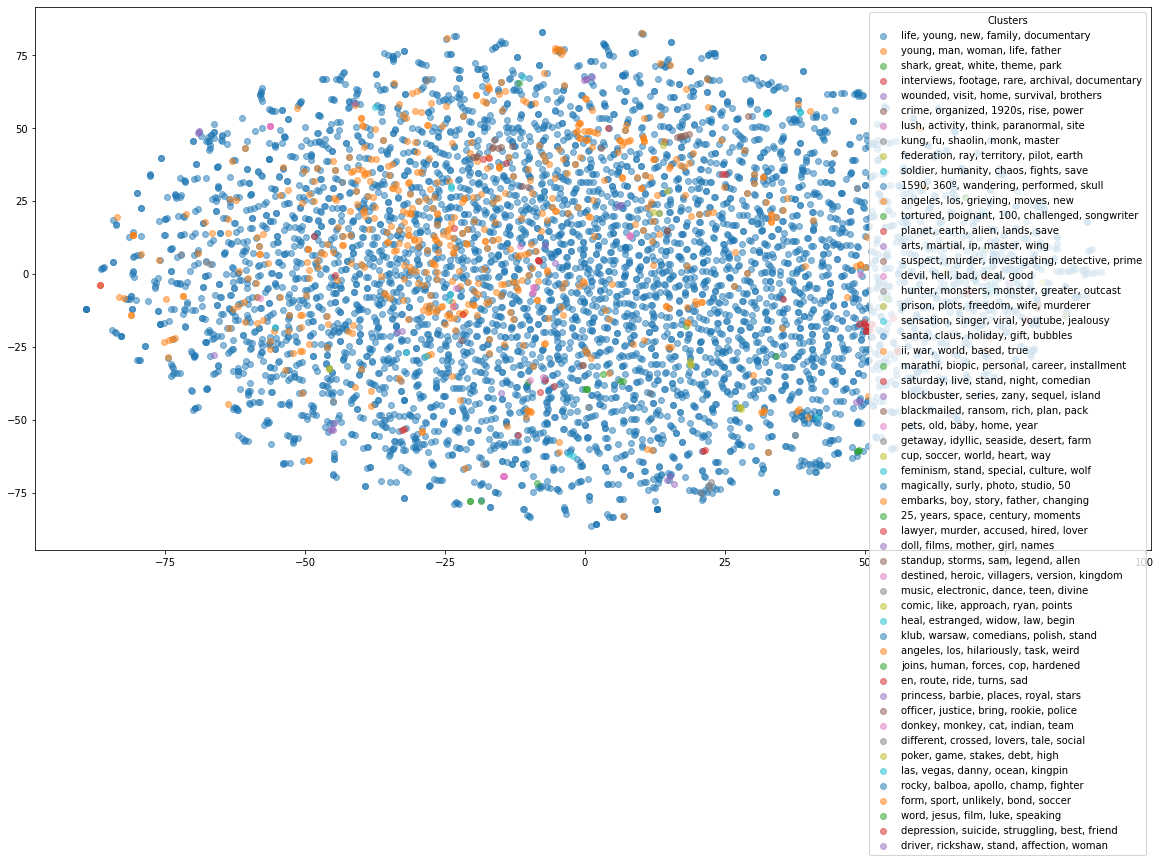

In [87]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(metric='cosine', eps=0.1, min_samples=3).fit(X_300d.values)

cluster_visualisation(X_2d, dbscan.labels_, cluster_names(X, dbscan.labels_))

## Иерархическая агломеративная кластеризация

Используя [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) кластеризуйте фильмы, 

подобрав оптимальное число кластеров и визуализировав наиболее значемые из них: 

In [36]:
from scipy.cluster.hierarchy import linkage, fcluster, leaders

linked = linkage(X.values, method='average', metric='cosine')

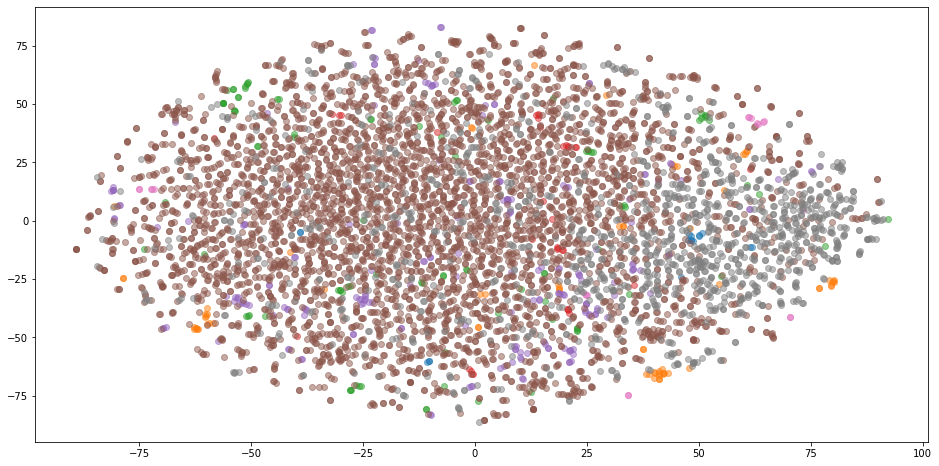

In [37]:
labels = fcluster(linked, 8, criterion='maxclust')

plt.figure(figsize=(16, 8))
    
for label in set(labels):
    plt.scatter(*zip(*X_2d[labels == label]), alpha=0.5)
    
plt.show()

In [38]:
unique_labels, counts = np.unique(labels, return_counts=True)

thr = 100
for label, count in zip(unique_labels, counts):
    if count > thr:
        print(f'{label} : {count}')
        
unique_labels = unique_labels[counts > thr]

5 : 203
6 : 4416
8 : 1271


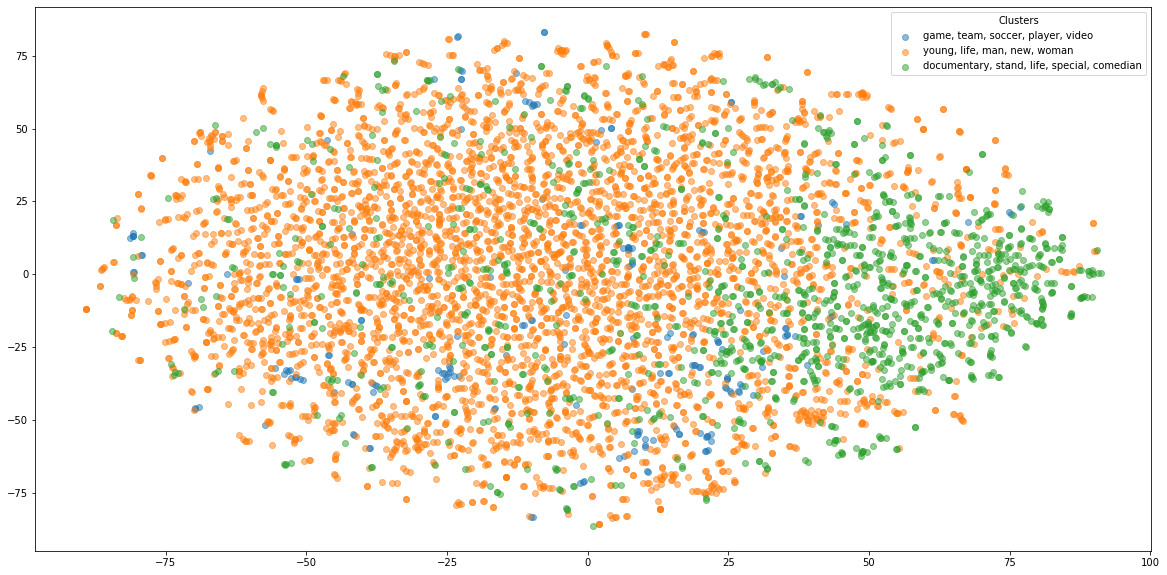

In [39]:
flags = [label in unique_labels for label in labels]
cut_labels = labels[flags]

cluster_visualisation(X_2d[flags], cut_labels, cluster_names(X[flags], cut_labels))